# Data gathering

## Imports

In [5]:
#%matplotlib inline
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
from matplotlib.ticker import FormatStrFormatter

params = {'axes.labelsize': 'large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pl.rcParams.update(params)

unfiltered_data = pd.read_table('final_data_updated.csv', delimiter=',')

## Remove corrupted or invalid data

In [6]:
invalid_value_mask = np.equal(unfiltered_data, -1)
invalid_rows_mask = np.any(invalid_value_mask, axis=1)
data = unfiltered_data[~invalid_rows_mask]

## Specific projects

In [7]:
data = data.loc[data['Project'].isin(['Math', 'Time', 'Lang', 'Closure', 'Chart'])]
print(data['Project'].unique())

['Chart' 'Closure' 'Lang' 'Math' 'Time']


## Label

In [8]:
label = 'L-10'
y = data[label]

## Dataset split method

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def createTestSet(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scaler = MinMaxScaler()
    X_train = getScaledDataset(X_train)
    X_test = getScaledDataset(X_test)
    return (X_train, X_test, y_train, y_test)

def getScaledDataset(X):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X)

# GridSearch

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#X = data.filter(regex="(S|D|T|B)-.*")
X = data[['S-WordCount', 'T-AvgVEFT', 'T-%VEP^FT', 'B-SizeInLines']]

X_train, X_test, y_train, y_test = createTestSet(X,y)

parameters = {'n_neighbors':range(1,20)}
clf = GridSearchCV(KNeighborsClassifier(), parameters, n_jobs=-1, cv=5)
clf.fit(X=X_train, y=y_train)

parameter = clf.best_params_
model = clf.best_estimator_

print("GridSearch training set results:")
print(clf.best_score_, parameter)
print("Score on test set:")
print(model.score(X_test, y_test))
print("Score on whole dataset:")
print(model.score(getScaledDataset(X), y))

GridSearch training set results:
0.868421052631579 {'n_neighbors': 16}
Score on test set:
0.8656716417910447
Score on whole dataset:
0.8708708708708709


# Visualization

<IPython.core.display.Javascript object>


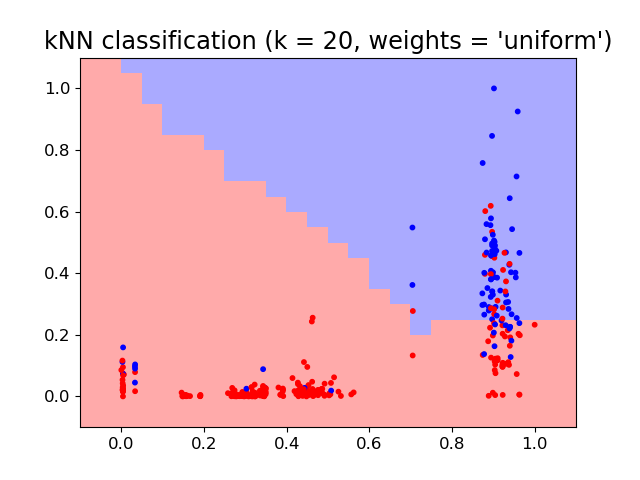

<IPython.core.display.Javascript object>


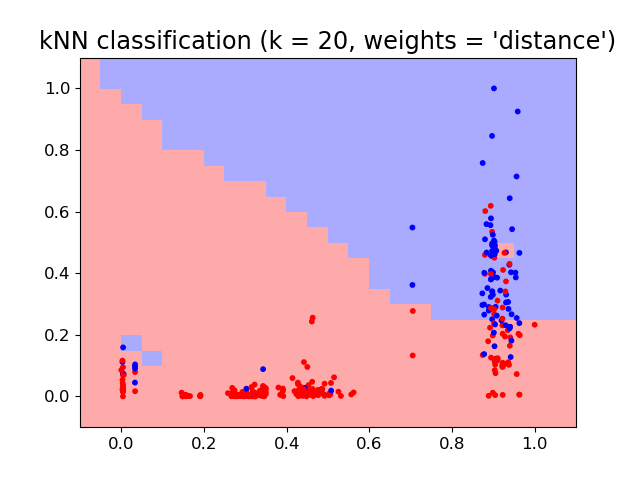

In [11]:
from matplotlib.colors import ListedColormap
#step size in the mesh
h = 0.05
border = 0.1
k=20
X = getScaledDataset(data[['S-LineCount', 'T-AvgVEFT']])

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    clf = KNeighborsClassifier(k, weights=weights)
    clf.fit(X, y)

    x_min, x_max = X[:, 0].min() - border, X[:, 0].max() + border
    y_min, y_max = X[:, 1].min() - border, X[:, 1].max() + border
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=10)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("kNN classification (k = %i, weights = '%s')" % (k, weights))